In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

In [262]:
%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size': 15})

In [4]:
from attU.sql import psql_load

## Load Data

In [5]:
df = pd.read_pickle('cleaned_eligibility_data')

9495 unique tickets for 12845 comments in our restricted set, removing 'chat ended' comments.

**Ignored**:  
ticket tags, requester tags, author tags  
account number, call duration, voice type, comment id, author name, author id

## Label tickets that contain just macro responses or are follow ups to queries

Find tickets that don't contain timestamps, and from those find macros

In [7]:
df['text_type'] = df.comment_text.\
map(lambda x: re.search(r'\((1[0-2]|0?[1-9]):([0-5]?[0-9]):([0-5]?[0-9]) ([AP]M)?\)', x)).\
map(lambda x: 'chat' if x else 'macro')

### ID lines from requester

Assuming first line is from requester (only true for non-macro, first interaction tickets)

In [527]:
df_first_chat = df[df.text_type=='chat'].drop_duplicates(subset=['t_id']).copy()

In [628]:
re.search(r'\(.+:.+:.+ [AP]M\) (.+?):', df_first_chat.iloc[0].comment_text.split('\n')[1]).group(0)

'(09:57:41 PM) Jeannie:'

In [1243]:
print(df_first_chat.iloc[0].comment_text)

 
(09:57:41 PM) Jeannie: Hi
(09:58:11 PM) Shane C.: Hi Jeannie
(09:58:13 PM) Shane C.: How are you?
(09:58:22 PM) Jeannie: HI Shane
(09:58:50 PM) Jeannie: In reg to quote for "Fresh Donuts Inc"
(09:58:58 PM) Jeannie: they are bakery with cooking
(09:59:06 PM) Jeannie: not sure what's the best class I should go with
(09:59:47 PM) Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops
(09:59:53 PM) Jeannie: not sure if this is appropriate?
(10:00:00 PM) Jeannie: there is no specific bakery with cooking
(10:00:11 PM) Shane C.: Bakeries-Retail-With Baking on Premises 71311
(10:00:37 PM) Shane C.: I think this would be the best class code under processing and servicing
(10:01:12 PM) Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
(10:02:47 PM) Jeannie: Have a great day. TY
(10:03:07 PM) Shane C.: My pleasure. Is there anything else I can help with at the moment?
(10:03:19 PM) Jeannie: I'm good now. TY :)
(10:03:39

In [632]:
def separate_chats(text):
    customer_chats = []
    agent_chats = []
    #
    for line in text.split('\n'):
        #check for timestamp-name pair in chat
        search = re.search(r'\(.+:.+:.+ [AP]M\) (.+?):', line)
        if search:
            #extract name
            name = search.group(1)
            #remove timestamp-name from chat
            line=line.replace(search.group(0),'').strip()
            if not customer_chats:
                c_name=name
                customer_chats.append(line)
            elif name==c_name:
                customer_chats.append(line)
            else:
                agent_chats.append(line)
    return [customer_chats, agent_chats]

In [1239]:
separate_chats(df_first_chat.iloc[0].comment_text)

[['Hi',
  'HI Shane',
  'In reg to quote for "Fresh Donuts Inc"',
  'they are bakery with cooking',
  "not sure what's the best class I should go with",
  'I choose on buz category for Restaurant fast food, class as Donut shops',
  'not sure if this is appropriate?',
  'there is no specific bakery with cooking',
  'How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)',
  'Have a great day. TY',
  "I'm good now. TY :)"],
 ['Hi Jeannie',
  'How are you?',
  'Bakeries-Retail-With Baking on Premises 71311',
  'I think this would be the best class code under processing and servicing',
  'My pleasure. Is there anything else I can help with at the moment?',
  'Any time. Enjoy the rest of your night :)']]

In [634]:
separated_chats = df_first_chat.comment_text.map(separate_chats)

In [639]:
df_first_chat['customer_chats'] = separated_chats.map(lambda x: x[0])

In [640]:
df_first_chat['agent_chats'] = separated_chats.map(lambda x: x[1])

In [1217]:
print(df_first_chat.iloc[0].comment_text)

 
(09:57:41 PM) Jeannie: Hi
(09:58:11 PM) Shane C.: Hi Jeannie
(09:58:13 PM) Shane C.: How are you?
(09:58:22 PM) Jeannie: HI Shane
(09:58:50 PM) Jeannie: In reg to quote for "Fresh Donuts Inc"
(09:58:58 PM) Jeannie: they are bakery with cooking
(09:59:06 PM) Jeannie: not sure what's the best class I should go with
(09:59:47 PM) Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops
(09:59:53 PM) Jeannie: not sure if this is appropriate?
(10:00:00 PM) Jeannie: there is no specific bakery with cooking
(10:00:11 PM) Shane C.: Bakeries-Retail-With Baking on Premises 71311
(10:00:37 PM) Shane C.: I think this would be the best class code under processing and servicing
(10:01:12 PM) Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
(10:02:47 PM) Jeannie: Have a great day. TY
(10:03:07 PM) Shane C.: My pleasure. Is there anything else I can help with at the moment?
(10:03:19 PM) Jeannie: I'm good now. TY :)
(10:03:39

Using name fields in database

In [29]:
df.r_name.map(lambda x: len(x.split())).value_counts()

2    9401
1    3137
3     249
4      41
5      14
6       3
Name: r_name, dtype: int64

In [32]:
df.a_name.value_counts()

Amit K.         2103
Shane C.        1698
Jessica P.      1511
Connor A.       1451
Mellisa M.      1150
David R.        1004
Andrianna Q.     842
Manaan A.        756
Steven L.        652
Brian H          271
Ashl'Y M.        251
Lawanda B.       212
Nipon S          182
Tamika M.        130
Dana H.          103
Andre K.         100
Tristan S.        93
Barrett S         69
Andrew C.         64
Jordan B.         50
Alexander G.      43
Diana A.          40
Andre Karma       25
Makeba K.         22
Aaliyah B         19
Brandi A.          3
Daniel B.          1
Name: a_name, dtype: int64

In [56]:
def name_present(row):
    first_name = row['a_name'].split()[0]
    text = row['comment_text']
    if re.search(r'\(.+:.+:.+ ([AP]M)\) '+first_name, text):
        return True
    else:
        return False

In [64]:
print(df[df.text_type=='chat'][~df[df.text_type=='chat'].apply(name_present,axis=1)].iloc[0].comment_text)

 
(08:58:06 PM) Ashley : Insured installs drapery &amp; shdes
Is the furniture/fixture install the correct classification?
(09:01:53 PM) Mellisa M.: Hi Ashley
(09:01:59 PM) Mellisa M.: One moment while I confirm
(09:04:53 PM) Mellisa M.: Yes, house furnishing installation is fine
(09:10:07 PM) Mellisa M.: Is there anything else I can help you with today Ashley?



### Timestamp features

In [179]:
def extract_ts_features(row):
    try:
        text = row['comment_text']
        ts = [pd.to_datetime(tstring.replace('(','').replace(')','')) for tstring \
              in re.findall(r'\(.+:.+:.+M\)', text)]
        total = (ts[-1]-ts[0]).total_seconds()/60
        diffs = [d.total_seconds()/60 for d in np.diff(ts)]
        return [row['t_id'],total, np.mean(diffs), np.max(diffs), np.std(diffs)]
    except:
        #print(row['t_id'])
        return None

In [643]:
#consider only chat tickets and keep the first of duplicate ticket IDs
ts_features = pd.DataFrame(data=df_first_chat.apply(extract_ts_features,axis=1).dropna().array,
                           columns=['t_id','total_time','mean_diff','max_diff','std_diff'])

//anaconda3/envs/zendesk/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/envs/zendesk/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [644]:
ts_features['round_total_time'] = ts_features.total_time.round()

1/3 of tickets take under ~3.5 minutes,   
2/3 under ~8.5 minutes

Text(0.5, 1.0, 'Cumulative Percentage of all tickets by time spent')

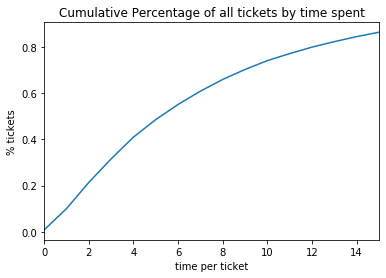

In [645]:
#cumulative percentage of num tickets per bucket of rounded time spent per ticket
fig, ax = plt.subplots()

(ts_features.groupby('round_total_time')['t_id'].count().cumsum()/\
 ts_features.t_id.unique().size)[:15].\
plot(ax=ax)

ax.set_ylabel('% tickets')
ax.set_xlabel('time per ticket')
ax.set_title('Cumulative Percentage of all tickets by time spent')

In [646]:
#round, group by time, count
# multiply count*time to find total time used by small tickets
tix_by_time_bucket = pd.DataFrame(
    ts_features.groupby('round_total_time')['t_id'].count()
).rename(columns={'t_id':'tid_count'}).reset_index()

In [647]:
def time_all_tickets(row):
    ticket_time_bin = row['round_total_time']
    tc = row['tid_count']
    if ticket_time_bin==0:
        return 0.5*tc
    else:
        return ticket_time_bin*tc

In [648]:
tix_by_time_bucket['time_all_tickets'] = tix_by_time_bucket.apply(time_all_tickets, axis=1)

Text(0.5, 1.0, 'Cumulative Percentage of time spent on tickets, by time per ticket')

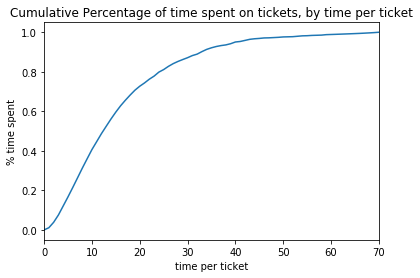

In [649]:
fig, ax = plt.subplots()

(tix_by_time_bucket.time_all_tickets.cumsum()/tix_by_time_bucket.time_all_tickets.sum()).plot(ax=ax)

ax.set_ylabel('% time spent')
ax.set_xlabel('time per ticket')
ax.set_title('Cumulative Percentage of time spent on tickets, by time per ticket')

Text(0.5, 1.0, 'Percentage of time spent on tickets, by time per ticket')

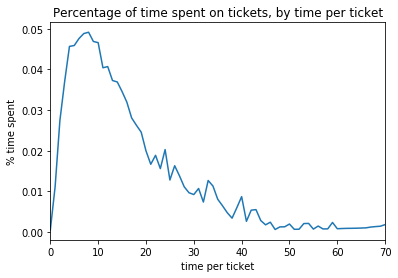

In [650]:
fig, ax = plt.subplots()

(tix_by_time_bucket.time_all_tickets/tix_by_time_bucket.time_all_tickets.sum()).plot(ax=ax)

ax.set_ylabel('% time spent')
ax.set_xlabel('time per ticket')
ax.set_title('Percentage of time spent on tickets, by time per ticket')

### Let's look at tickets under 10 minutes, perhaps breaking down by <3, <10 subgroups since they constitute 50% of all time spent by agents

Add line counts feature

In [653]:
df_first_chat['line_counts'] = df_first_chat.comment_text.str.count('\n')

In [654]:
df_first_chat.count()

t_id              9482
t_created         9482
r_name            9482
r_id              9482
a_id              9482
a_name            9482
subject           9481
comment_text      9482
text_type         9482
line_counts       9482
customer_chats    9482
agent_chats       9482
dtype: int64

In [657]:
df_first_chat.count()

t_id              9482
t_created         9482
r_name            9482
r_id              9482
a_id              9482
a_name            9482
subject           9481
comment_text      9482
text_type         9482
line_counts       9482
customer_chats    9482
agent_chats       9482
dtype: int64

In [658]:
ts_features.count()

t_id                9458
total_time          9458
mean_diff           9458
max_diff            9458
std_diff            9458
round_total_time    9458
dtype: int64

In [659]:
#merge ts and linecounts features
non_text_features = ts_features.merge(df_first_chat[['t_id','line_counts']].dropna(), on='t_id', how='left')

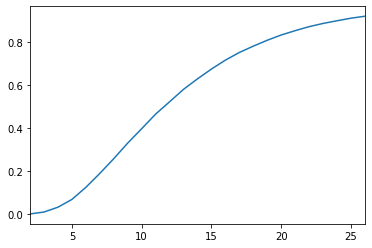

In [660]:
#explore line counts
(non_text_features.line_counts.value_counts().sort_index().cumsum()/non_text_features.t_id.unique().size)\
[:25].plot()

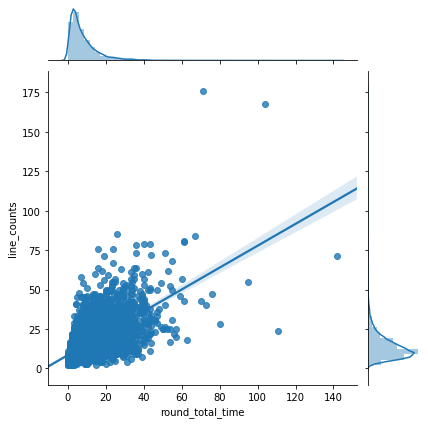

In [661]:
#correlate lines and time
sns.jointplot(non_text_features.round_total_time, non_text_features.line_counts, 
              kind='reg')

In [662]:
non_text_features.corr()

total_time  mean_diff  max_diff  std_diff  round_total_time  \
total_time          1.000000   0.532267  0.762493  0.654258          0.999390   
mean_diff           0.532267   1.000000  0.725684  0.798454          0.531350   
max_diff            0.762493   0.725684  1.000000  0.948444          0.761824   
std_diff            0.654258   0.798454  0.948444  1.000000          0.653521   
round_total_time    0.999390   0.531350  0.761824  0.653521          1.000000   
line_counts         0.642470  -0.048689  0.239735  0.089710          0.642170   

                  line_counts  
total_time           0.642470  
mean_diff           -0.048689  
max_diff             0.239735  
std_diff             0.089710  
round_total_time     0.642170  
line_counts          1.000000

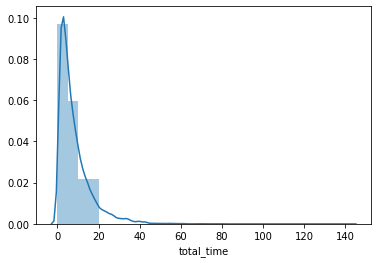

In [663]:
sns.distplot(ts_features.total_time, bins=[0,5,10,20])

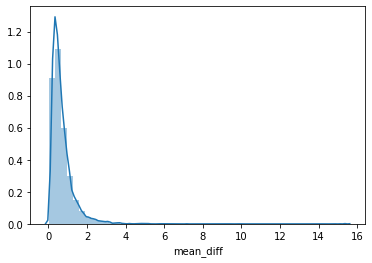

In [664]:
sns.distplot(ts_features.mean_diff)

### try clustering on non-text features

In [669]:
non_text_features.describe()

total_time    mean_diff     max_diff     std_diff  round_total_time  \
count  9458.000000  9458.000000  9458.000000  9458.000000       9458.000000   
mean      8.255359     0.710083     2.803397     0.801478          8.260203   
std       8.283439     0.654040     3.083133     0.879552          8.286841   
min       0.100000     0.050000     0.083333     0.000000          0.000000   
25%       2.850000     0.336111     0.950000     0.277236          3.000000   
50%       5.666667     0.542168     1.883333     0.544205          6.000000   
75%      10.762500     0.869768     3.500000     0.998658         11.000000   
max     142.316667    15.416667    54.966667    13.008641        142.000000   

       line_counts  
count  9458.000000  
mean     14.219391  
std       8.944956  
min       2.000000  
25%       8.000000  
50%      12.000000  
75%      17.000000  
max     176.000000

In [1218]:
cols = non_text_features.columns[[1,-2,-1]]
cols

Index(['total_time', 'k3', 'k2'], dtype='object')

In [671]:
X = non_text_features[cols].values

In [672]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
import time

In [673]:
inertia = []
K = range(1,6)

for k in K:
    time_start = time.time()
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=300)
    km = km.fit(minmax_scale(X))
    inertia.append(km.inertia_)
    print('kmeans {} done! Time elapsed: {} seconds'.format(k,time.time()-time_start))

kmeans 1 done! Time elapsed: 0.07269620895385742 seconds
kmeans 2 done! Time elapsed: 0.07332801818847656 seconds
kmeans 3 done! Time elapsed: 0.09389114379882812 seconds
kmeans 4 done! Time elapsed: 0.16785812377929688 seconds
kmeans 5 done! Time elapsed: 0.20804524421691895 seconds


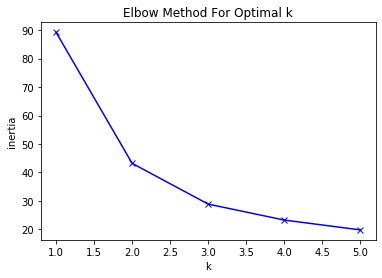

In [674]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [675]:
non_text_features['k3'] = KMeans(n_clusters=3, 
                                 random_state=0, n_init=10, max_iter=300).fit_predict(minmax_scale(X))

non_text_features['k2'] = KMeans(n_clusters=2, 
                                 random_state=0, n_init=10, max_iter=300).fit_predict(minmax_scale(X))

In [676]:
non_text_features.k3.value_counts()

0    6172
2    2744
1     542
Name: k3, dtype: int64

In [677]:
non_text_features.k2.value_counts()

1    7723
0    1735
Name: k2, dtype: int64

### Examine clusters

In [1220]:
non_text_features.describe()

total_time    mean_diff     max_diff     std_diff  round_total_time  \
count  9458.000000  9458.000000  9458.000000  9458.000000       9458.000000   
mean      8.255359     0.710083     2.803397     0.801478          8.260203   
std       8.283439     0.654040     3.083133     0.879552          8.286841   
min       0.100000     0.050000     0.083333     0.000000          0.000000   
25%       2.850000     0.336111     0.950000     0.277236          3.000000   
50%       5.666667     0.542168     1.883333     0.544205          6.000000   
75%      10.762500     0.869768     3.500000     0.998658         11.000000   
max     142.316667    15.416667    54.966667    13.008641        142.000000   

       line_counts           k3           k2  
count  9458.000000  9458.000000  9458.000000  
mean     14.219391     0.637556     0.816557  
std       8.944956     0.900785     0.387049  
min       2.000000     0.000000     0.000000  
25%       8.000000     0.000000     1.000000  
50%      12.000000     0.000000     1.000000  
75%      17.000000     2.000000     1.000000  
max     176.000000     2.000000     1.000000

In [678]:
non_text_features[non_text_features.k3==0].describe()

total_time    mean_diff     max_diff     std_diff  round_total_time  \
count  6172.000000  6172.000000  6172.000000  6172.000000       6172.000000   
mean      3.965241     0.534859     1.606743     0.504744          3.968730   
std       2.336497     0.432390     1.286930     0.460854          2.341836   
min       0.100000     0.050000     0.083333     0.000000          0.000000   
25%       2.050000     0.283333     0.716667     0.204701          2.000000   
50%       3.616667     0.428869     1.233333     0.374343          4.000000   
75%       5.566667     0.645833     2.083333     0.641229          6.000000   
max      11.483333     9.333333     9.350000     4.249706         11.000000   

       line_counts      k3      k2  
count  6172.000000  6172.0  6172.0  
mean     10.260855     0.0     1.0  
std       4.129488     0.0     0.0  
min       2.000000     0.0     1.0  
25%       7.000000     0.0     1.0  
50%      10.000000     0.0     1.0  
75%      13.000000     0.0     1.0  
max      29.000000     0.0     1.0

In [1222]:
non_text_features[non_text_features.k3==1].describe()

total_time   mean_diff    max_diff    std_diff  round_total_time  \
count  542.000000  542.000000  542.000000  542.000000        542.000000   
mean    32.375707    1.463972    8.743419    2.128667         32.389299   
std     11.538206    1.116257    6.336552    1.684047         11.527902   
min     15.700000    0.228638    1.433333    0.217364         16.000000   
25%     25.791667    0.853488    4.566667    1.069889         26.000000   
50%     29.650000    1.148889    6.925000    1.627011         30.000000   
75%     35.283333    1.727959   10.983333    2.610342         35.000000   
max    142.316667   15.350000   54.966667   13.008641        142.000000   

       line_counts     k3     k2  
count   542.000000  542.0  542.0  
mean     31.937269    1.0    0.0  
std      16.813639    0.0    0.0  
min       4.000000    1.0    0.0  
25%      21.000000    1.0    0.0  
50%      29.000000    1.0    0.0  
75%      39.000000    1.0    0.0  
max     176.000000    1.0    0.0

In [679]:
non_text_features[non_text_features.k3==0].head()

t_id  total_time  mean_diff  max_diff  std_diff  round_total_time  \
0  148945    5.966667   0.372917  1.583333  0.364286               6.0   
3  148929    1.800000   0.257143  0.400000  0.112637               2.0   
4  148925    3.233333   0.359259  0.716667  0.236632               3.0   
7  148903    5.150000   0.735714  3.600000  1.198459               5.0   
9  148864    6.433333   1.286667  3.466667  1.210803               6.0   

   line_counts  k3  k2  
0           17   0   1  
3            8   0   1  
4           10   0   1  
7           11   0   1  
9            9   0   1

In [680]:
df_pipe = df_first_chat.\
merge(non_text_features, on='t_id', how='left').dropna().drop('line_counts_x',axis=1).\
rename(columns={'line_counts_y':'line_counts'})

In [1223]:
for i in df_pipe[(df_pipe.k3==0)].comment_text.sample(5):
    print('-------------')
    print(i)

-------------
 
(01:28:05 PM) Carlos: hi
(01:28:22 PM) Steven: Hi, my name is Steven. How are you?
(01:28:57 PM) Carlos: I have a vitamin/ nutrition supplements store would this be ok to put under the drugstore class code?
(01:30:05 PM) Steven: No. We would not write vitamin/ nutrition supplements stores at time.
(01:31:34 PM) Carlos: ok thanks
(01:31:49 PM) Steven: Thank you for thinking of Attune!

-------------
 
(07:02:19 PM) Sarah Collier: I have a client that is looking to do a shop/store for the CBD Oil and Kratom? Can you guys write this particular risk?
(07:03:07 PM) Andrianna Q.: Hi Sarah
(07:03:11 PM) Andrianna Q.: Good Afternoon!
(07:03:23 PM) Sarah Collier: Good Afternoon
(07:03:53 PM) Andrianna Q.: unfortunately, this risk is not in our appetite at the moment
(07:04:11 PM) Sarah Collier: Ok Thanks!
(07:04:55 PM) Andrianna Q.: you're welcome
(07:04:58 PM) Andrianna Q.: is there anything else I can help you with today?
(07:05:20 PM) Sarah Collier: no that is it. Have a Grea

In [684]:
#get df of raw, features and cluster labels
df_pipe.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
2  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
3  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   
4  148925 2019-09-19 21:19:42     Vincent Mosomillo  363659707672   

           a_id    a_name                     subject  \
0  374984390592  Shane C.           Chat with Jeannie   
1  374984390592  Shane C.            Chat with denise   
2  374984390592  Shane C.         Chat with jeff wolf   
3  374984390592  Shane C.    Chat with georgette diaz   
4  374984390592  Shane C.  Chat with Vncent Mosomillo   

                                        comment_text text_type  \
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...      chat   
1   \n(09:22:45 PM) denise: Do you allow electric...      chat   
2   \n(09:21:52 PM) jeff wolf: what is best class...      chat   
3   \n(09:21:24 PM) georgette diaz: quick questio...      chat   
4   \n(09:19:05 PM) Vncent Mosomillo: Question\n(...      chat   

                                      customer_chats  \
0  [Hi, HI Shane, In reg to quote for "Fresh Donu...   
1  [Do you allow electrical contractors to instal...   
2  [what is best classification for fence erectio...   
3  [quick question what bakery classification do ...   
4  [Question, Been Better, Question, Commercial C...   

                                         agent_chats  total_time  mean_diff  \
0  [Hi Jeannie, How are you?, Bakeries-Retail-Wit...    5.966667   0.372917   
1  [Hi Denise, How are you?, I am doing well. Alm...   13.750000   1.375000   
2  [Hi Jeff, How are you?, Fence Erection Contrac...   19.883333   0.414236   
3  [Hi Georgette, How are you?, That is good to h...    1.800000   0.257143   
4  [Hi Vincent, How are you?, Sure thing. Happy t...    3.233333   0.359259   

   max_diff  std_diff  round_total_time  line_counts   k3   k2  
0  1.583333  0.364286               6.0         17.0  0.0  1.0  
1  3.583333  1.163907              14.0         12.0  2.0  1.0  
2  3.033333  0.500613              20.0         50.0  1.0  0.0  
3  0.400000  0.112637               2.0          8.0  0.0  1.0  
4  0.716667  0.236632               3.0         10.0  0.0  1.0

Examine text of clusters

In [1531]:
for i in df_pipe[(df_pipe.k3==0)].sample(5)[['comment_text','customer_chats']].iterrows():
    print('-------------')
    print(i[1]['comment_text'])
    print('CCCCCCCCCC')
    print(' '.join(i[1]['customer_chats'][:]))

-------------
 
(03:32:57 PM) Robert Guerra: I would like to see if a contractor that services and installs water meters would be acceptable. I guess it would be light electrical.
(03:33:06 PM) Amit: Hey RObert
(03:33:20 PM) Amit: i don't know if we have a BOP class for this that would fit
(03:35:16 PM) Amit: what is it classed as now
(03:35:57 PM) Robert Guerra: He currently does not have coverage.
(03:36:30 PM) Amit: I don't think we have a class that encompassses this
(03:36:48 PM) Robert Guerra: OK. Thank You
(03:36:57 PM) Amit: no problem
(03:36:58 PM) Amit: take care

CCCCCCCCCC
I would like to see if a contractor that services and installs water meters would be acceptable. I guess it would be light electrical. He currently does not have coverage. OK. Thank You
-------------
 
(06:50:35 PM) phil : i am looking to write a candy store with you building and contents what code would i use?
(06:51:19 PM) Andrianna Q.: Hi Phil
(06:51:22 PM) Andrianna Q.: good afternoon
(06:51:36 PM) ph

Cleaning, stopwords, bi- and tri-grams, lemmatization

In [738]:
#remove spaces, lower, stopwords, lemma?
from gensim.utils import simple_preprocess

//anaconda3/envs/zendesk/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
//anaconda3/envs/zendesk/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
//anaconda3/envs/zendesk/lib/python3.7/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import namedtuple, defaultdict, Iterable


In [743]:
import nltk; nltk.download('stopwords')

//anaconda3/envs/zendesk/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
//anaconda3/envs/zendesk/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sugreevchawla/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Stopwords

In [968]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [930]:
#translations of ampersand
df_pipe.customer_chats.map(lambda x: 'amp' in x)

False    9457
Name: customer_chats, dtype: int64

In [1084]:
custom = ['hi','good','hey','hello','thank','thanks','morning',
             'afternoon','evening','please','ok','okay','great','welcome','day','today',
            'would','yes','amp']

In [1085]:
insurance = ['attune','blackboard']

In [1086]:
stop_words.extend(custom); stop_words.extend(insurance)

In [1087]:
#get list of agent names to remove
agent_names = [n.split()[0].lower() for n in df.a_name.unique()]

In [1088]:
stop_words.extend(agent_names)

In [1530]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [900]:
import gensim
import spacy

//anaconda3/envs/zendesk/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
//anaconda3/envs/zendesk/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [915]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [1089]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [1122]:
make_bigrams(df_pipe.customer_chats.map(remove_stopwords).values)

[['reg',
  'quote',
  'fresh',
  'donuts',
  'inc',
  'bakery',
  'cooking',
  'sure',
  'best',
  'class',
  'go',
  'choose',
  'buz',
  'category',
  'restaurant_fast',
  'food',
  'class',
  'donut',
  'shops',
  'sure',
  'appropriate',
  'specific',
  'bakery',
  'cooking',
  'bakery',
  'goes',
  'processing',
  'servicing',
  'lol',
  'found',
  'bakeries',
  'class',
  'ty_ty',
  'ty'],
 ['allow',
  'electrical',
  'contractors',
  'install',
  'solar',
  'panels',
  'ready',
  'friday',
  'bummer',
  'make',
  'note',
  'nope'],
 ['best',
  'classification',
  'fence_erection',
  'staining',
  'staining',
  'tiny',
  'part',
  'mix',
  'fine',
  'residential',
  'wood',
  'fences',
  'system',
  'wood',
  'fence',
  'pickets',
  'polling',
  'rails',
  'treating',
  'put',
  'class_code',
  'work',
  'description',
  'used',
  'put',
  'looks',
  'like',
  'took',
  'way',
  'gl',
  'everything',
  'bop',
  'help',
  'payroll',
  'zero',
  'assume',
  'something',
  'go',
  '

In [1090]:
# Define functions for stopwords, bigrams, trigrams and lemmatization,yield list of docs

def remove_stopwords(doc):
    #remove accents, keep words 2-15 chars, lower, remove stopwords
    #applied to list of chat lines
    return [word for word in simple_preprocess(' '.join(doc), deacc=True) if word not in stop_words]

def make_bigrams(docs):
    return [bigram_mod[doc] for doc in docs]

def make_trigrams(docs):
    return [trigram_mod[bigram_mod[doc]] for doc in docs]

def lemmatization(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN']):
    """https://spacy.io/api/annotation"""
    docs_out = []
    for sent in docs:
        doc = nlp(" ".join(sent)) 
        docs_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return docs_out

In [1091]:
#remove stop
docs = df_pipe.customer_chats.map(remove_stopwords).values

In [1092]:
#bigrams/tokenize, lemmatize
docs = lemmatization(make_bigrams(docs), 
                     allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [1093]:
df_pipe['clean_customer_chats'] = docs

In [1094]:
df_pipe.head(2)

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   

           a_id    a_name            subject  \
0  374984390592  Shane C.  Chat with Jeannie   
1  374984390592  Shane C.   Chat with denise   

                                        comment_text text_type  \
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...      chat   
1   \n(09:22:45 PM) denise: Do you allow electric...      chat   

                                      customer_chats  \
0  [Hi, HI Shane, In reg to quote for "Fresh Donu...   
1  [Do you allow electrical contractors to instal...   

                                         agent_chats  total_time  mean_diff  \
0  [Hi Jeannie, How are you?, Bakeries-Retail-Wit...    5.966667   0.372917   
1  [Hi Denise, How are you?, I am doing well. Alm...   13.750000   1.375000   

   max_diff  std_diff  round_total_time  line_counts   k3   k2  \
0  1.583333  0.364286               6.0         17.0  0.0  1.0   
1  3.583333  1.163907              14.0         12.0  2.0  1.0   

                                clean_customer_chats  
0  [reg, fresh, donut, inc, bakery, cook, sure, g...  
1  [allow, electrical, contractor, install, solar...

Compare processed to original

In [1532]:
for i in df_pipe[(df_pipe.k3==0)].sample(5)[['customer_chats','clean_customer_chats']].iterrows():
    print('-------------')
    print('ORIGINAL\n')
    print(' '.join(i[1]['customer_chats'])+'\n')
    print('CLEANED\n')
    print(' '.join(i[1]['clean_customer_chats']))

-------------
ORIGINAL

Hello, do you guys have a market for dairy products manufacturing? OK thank you! you too

CLEANED

guy market dairy product manufacturing
-------------
ORIGINAL

Hello. Do you write BOPS on convenience stores with gas sales that are 24 hours? okay - thank you!

CLEANED

write bop convenience store gas sale hour
-------------
ORIGINAL

Hi again, Does Attune write for a renting warehouse in Lake Charles, LA for storage of restaurant togo supply and dry food? If so, what class code to use? Thanks Yes, just the frame warehouse one of our insured rents for storage. No, that's all. Thanks.

CLEANED

write rent warehouse lake charle storage restaurant togo supply dry food class_code use frame warehouse insure rent storage
-------------
ORIGINAL

dog trainers? GL Thanks!

CLEANED

dog trainer
-------------
ORIGINAL

hi hi Amit quick question do you do GL PL for security guards? armed ok thanks

CLEANED

quick_question security guard arm


Count Vectorize

In [1124]:
df_pipe.clean_customer_chats.head()

0    [reg, fresh, donut, inc, bakery, cook, sure, g...
1    [allow, electrical, contractor, install, solar...
2    [good, classification, fence_erection, stainin...
3    [quick_question, bakery, classification, put, ...
4    [question, well, question, commercial, co, op,...
Name: clean_customer_chats, dtype: object

In [1097]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [1118]:
#prepare data for vectorizer, requires doc strings so join tokens
data = df_pipe[df_pipe.k3==0].clean_customer_chats.str.join(' ')

In [1136]:
# vectorize
vectorizer = CountVectorizer(min_df=4, max_df=0.90, max_features=3000)

In [1137]:
data_vectorized = vectorizer.fit_transform(data)

Examine vocabulary

In [1138]:
data_vectorized.sum(axis=0).shape

(1, 2188)

In [1139]:
sum_words = data_vectorized.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [1140]:
wfs = pd.DataFrame(pd.Series(words_freq),columns=['count'])

In [1141]:
wfs['len'] = wfs['count'].map(lambda x: len(x[0].split()))

In [1148]:
print(sorted(wfs[wfs.len==1]['count'].values, key=lambda x: x[1], reverse=True)[:15])
print('\n')
print(sorted(wfs[wfs.len==1]['count'].values, key=lambda x: x[1], reverse=False)[:15])

[('write', 1356), ('office', 1016), ('risk', 894), ('store', 834), ('class', 799), ('building', 774), ('use', 761), ('tenant', 735), ('quote', 731), ('get', 671), ('restaurant', 639), ('class_code', 607), ('lro', 594), ('see', 562), ('bop', 558)]


[('ect', 4), ('insuring', 4), ('carolina', 4), ('movie', 4), ('luxury', 4), ('plug', 4), ('pole', 4), ('gasoline', 4), ('final', 4), ('mine', 4), ('http_com', 4), ('plate', 4), ('decoration', 4), ('mornign', 4), ('appropriately', 4)]


TFIDF

In [ ]:
#get top n features and corresponding weights
n=10
top_n_tfidf_inds = np.fliplr(tfv.toarray().argsort(axis=1))[:,:n]
top_n_tfidf_weights = np.fliplr(np.sort(tfv.toarray(),axis=1))[:,:n]
top_n_tfidf_features = features_array[top_n_tfidf_inds]

### Topic modeling on 1st cluster, simple tickets

In [1150]:
from sklearn.decomposition import LatentDirichletAllocation

In [1151]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=0, 
                                learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [1152]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]) 

In [1154]:
selected_topics(lda, vectorizer)

Topic 0:
[('write', 573.0250707046368), ('bop', 258.2865843315998), ('guy', 174.7081421328884), ('appetite', 149.39387246298617), ('offer', 125.46354142589519), ('cover', 111.15628304066401), ('understand', 107.78503530061043), ('occupant', 96.80295785983857), ('property', 79.43980545498133), ('accept', 77.91261259383796)]
Topic 1:
[('office', 1029.4220887511033), ('write', 208.2721610628018), ('something', 165.3456829970264), ('warehouse', 162.95466347711837), ('company', 162.49018152842336), ('build', 128.36330186697006), ('building', 127.74736476932975), ('school', 89.60167439955973), ('use', 84.79505475075956), ('area', 82.38711010488971)]
Topic 2:
[('consider', 318.51509202186674), ('much', 143.5981217858363), ('lol', 121.58614420176644), ('sale', 117.58929411105728), ('weekend', 107.1902121401753), ('come', 101.93976907471378), ('contractor', 101.44558304008417), ('grocery_store', 91.4565493536097), ('small', 87.68137487938178), ('quick_question', 84.50579312603347)]
Topic 3:
[('

In [1164]:
import pprint

In [1166]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(data_vectorized))

# See model parameters
pprint.pprint(lda.get_params())

Log Likelihood:  -491359.8135622674
Perplexity:  1023.8234588317257
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': True}


### Grid Search

In [1167]:
from sklearn.model_selection import GridSearchCV

In [1246]:
# Define Search Param
search_params = {'n_components': [25, 30, 35, 40], 'learning_decay': [.7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

//anaconda3/envs/zendesk/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                  

In [1247]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 25}
Best Log Likelihood Score:  -184656.19474149408
Model Perplexity:  1276.8821136043596


In [1248]:
results_df = pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score')

In [1249]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_decay', 'param_n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [1250]:
results_df[['rank_test_score','params','mean_test_score']].sort_values(by='rank_test_score')

rank_test_score                                       params  \
0                1  {'learning_decay': 0.7, 'n_components': 25}   
4                2  {'learning_decay': 0.9, 'n_components': 25}   
1                3  {'learning_decay': 0.7, 'n_components': 30}   
5                4  {'learning_decay': 0.9, 'n_components': 30}   
2                5  {'learning_decay': 0.7, 'n_components': 35}   
6                6  {'learning_decay': 0.9, 'n_components': 35}   
3                7  {'learning_decay': 0.7, 'n_components': 40}   
7                8  {'learning_decay': 0.9, 'n_components': 40}   

   mean_test_score  
0   -184656.194741  
4   -185559.867417  
1   -186500.639118  
5   -187826.276653  
2   -188164.014577  
6   -189319.344379  
3   -189644.397388  
7   -191178.643356

In [1251]:
new_params = results_df.iloc[-2]['params']
tlda = model.best_estimator_.set_params(**new_params)

In [1252]:
tlda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [1253]:
tlda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

### Plotting LDA

In [1255]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn

In [ ]:
pyLDAvis.enable_notebook()
# dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

In [1499]:
# dash = pyLDAvis.sklearn.prepare(tlda, data_vectorized, vectorizer, mds='tsne')
# dash

In [1306]:
dash.token_table[dash.token_table['Topic']==16].sort_values('Freq',ascending=False).head()

Topic      Freq          Term
term                               
1        16  0.993523          able
517      16  0.992986      customer
1160     16  0.991500          loss
1393     16  0.990638          open
1683     16  0.990315  retail_store

### Get documents by topic

In [1257]:
# Create Document - Topic Matrix
model = tlda
lda_output = model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

In [1343]:
#check normalization of topic distriubtion by doc, it's not but whatever
df_document_topic.drop('dominant_topic', axis=1).apply(lambda x: x.sum(), axis=1).head()

Doc0    0.95
Doc1    0.95
Doc2    0.95
Doc3    0.90
Doc4    0.90
dtype: float64

In [1411]:
def ntopics_majority(row,frac):
    '''find nlargest of topics that constitute >=frac of all topics in a doc'''
    #sort, cumsum, indwhere
    c_frac = row.sort_values(ascending=False).cumsum()/row.sum()
    last_ind = c_frac[c_frac>=frac].index[0]
    return c_frac.loc[:last_ind].index.tolist()

In [1416]:
#get numbers of nonzero topics by doc
df_document_topic['nlargest_topics0.9'] = df_document_topic.drop(['dominant_topic','nlargest_topics0.9'], axis=1).\
apply(lambda x: ntopics_majority(x,.9),axis=1)

In [1418]:
#num topics that are .9 of topic dist per doc
df_document_topic['nlargest_topics0.9'].map(lambda x: len(x)).value_counts()

5     1033
6      883
4      829
29     736
7      618
8      503
3      340
9      337
10     181
30     171
11     124
36     103
31      91
2       78
12      69
13      33
14      16
1       13
16       5
15       4
17       3
18       2
Name: nlargest_topics0.9, dtype: int64

In [1422]:
#top 5
df_document_topic['nlargest_topics0.9'].map(lambda x: len(x[:5])).value_counts()

5    4912
4     829
3     340
2      78
1      13
Name: nlargest_topics0.9, dtype: int64

In [1423]:
df_document_topic['top5_topics'] = df_document_topic['nlargest_topics0.9'].map(lambda x: x[:5])

In [1464]:
#num docs by dominant topic
dt = set(df_document_topic.groupby('dominant_topic')['Topic0'].count().sort_values(ascending=False)[:15].index)
dt

{0, 4, 7, 10, 12, 14, 16, 18, 22, 26, 27, 33, 37, 38, 39}

In [1465]:
import itertools
tt = set(pd.Series(list(itertools.chain.from_iterable(df_document_topic.top5_topics.values))).value_counts()[:15].index)

In [1472]:
dt.union(set(map(lambda x: int(x[5:]),list(tt))))

{0, 4, 7, 10, 12, 14, 16, 18, 22, 26, 27, 32, 33, 37, 38, 39}

### representative docs per topic

In [1482]:
data.head()

0    reg fresh donut inc bakery cook sure good clas...
3    quick_question bakery classification put baker...
4    question well question commercial co op office...
7                                                 acct
9                                men_clothe wholesaler
Name: clean_customer_chats, dtype: object

In [1483]:
df_document_topic['index_data'] = data.index

In [1496]:
df_document_topic.groupby('dominant_topic')['index_data'].count().sort_values(ascending=False)[:15]

dominant_topic
4     563
37    501
26    465
7     342
10    342
39    315
33    287
27    285
18    272
16    231
22    224
12    222
14    203
0     185
38    171
Name: index_data, dtype: int64

In [1519]:
def get_representative_docs(topic_number):
    inds = df_document_topic.groupby('dominant_topic')['index_data'].get_group(topic_number).values
    return df_pipe.loc[inds].comment_text

In [1527]:
for i in get_representative_docs(7).sample(5):
    print('-------------')
    print(i)

-------------
 
(04:14:55 PM) Michelle: I'm trying to quote a convenient store is that something you'll write.
(04:15:29 PM) Steven: Hi there, this is not eligible.
(04:15:36 PM) Michelle: okay thanks
-------------
 
(03:41:39 PM) maureen o'neill: please confirm that you are not writing motels. Thank you.
Maureen
(03:42:12 PM) Connor: hi maureen
(03:42:18 PM) Connor: we are not writing motels at this time
(03:42:38 PM) maureen o'neill: OK thank you. Have a great day!

-------------
 
(04:15:51 PM) Elaena Whitman: Can you write a liquor store?
(04:16:12 PM) Connor: hi elaena
(04:16:20 PM) Elaena Whitman: hey connro
(04:16:24 PM) Elaena Whitman: connor
(04:16:27 PM) Connor: Beverage Stores – Liquor and Wine
(04:16:33 PM) Connor: 59215
(04:16:41 PM) Connor: this would be under mercantile/retail
(04:17:29 PM) Elaena Whitman: perfect thank you!
(04:17:29 PM) Connor: yes we can write them haha - should have led with that
(04:17:38 PM) Connor: of course!
(04:17:42 PM) Elaena Whitman: no worri

In [1501]:
dash

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
37      68.928055   69.402695       1        1  6.365099
26      30.743666   72.675629       2        1  6.249197
4       36.088337  127.030251       3        1  5.987266
10     104.519348   -6.638623       4        1  4.858865
39      95.198189  108.021866       5        1  4.760509
33     129.388153   69.570518       6        1  4.602345
27      41.635124   27.669353       7        1  4.201956
18     142.411621   33.384556       8        1  4.138888
14     140.742249  -34.675694       9        1  3.718924
16      87.277740   39.130116      10        1  3.708114
32     -67.934921   80.761040      11        1  3.540441
22      64.011215  -14.787541      12        1  3.529888
38    -141.870361   83.153328      13        1  3.375196
12      85.248688  148.164505      14        1  3.320778
7     -114.042397  135.613602      15        1  3.288688
28     -78.847809 -136.253540      16        1  2.976493
19    -128.210678  -91.288116      17        1  2.391543
29      87.851044  -70.878975      18        1  2.248392
23      -9.700549  102.202347      19        1  2.246691
35     145.584641  117.218285      20        1  2.006044
13    -163.873367  -40.543976      21        1  1.969248
9      -19.654930  164.308456      22        1  1.910261
25      32.716747  -51.875816      23        1  1.757854
5       37.768188 -105.510658      24        1  1.661864
11    -119.030212   -5.876472      25        1  1.525695
31    -105.386292   42.169399      26        1  1.459132
34     -14.736413  -79.854179      27        1  1.417932
20    -161.488068   24.327805      28        1  1.331988
36     -57.204357  124.688866      29        1  1.302572
2      -64.839249  -85.286018      30        1  1.233776
6      -17.065037 -131.081573      31        1  1.226883
0       13.088884   -7.010179      32        1  1.088667
24     -26.813580   60.310608      33        1  1.058115
8      -97.146095  -46.743309      34        1  0.765586
21     -60.612587   31.538223      35        1  0.652227
3      -13.241446   23.753962      36        1  0.564916
15     -52.965500  -41.547142      37        1  0.499876
17     -15.193813  -34.451019      38        1  0.488910
30     -72.194748   -5.695552      39        1  0.355239
1      -37.725273   -3.784532      40        1  0.213942, topic_info=     Category         Freq              Term        Total  loglift  logprob
2168  Default  1252.000000             write  1252.000000  30.0000  30.0000
1877  Default   801.000000             store   801.000000  29.0000  29.0000
1673  Default   620.000000        restaurant   620.000000  28.0000  28.0000
1377  Default   969.000000            office   969.000000  27.0000  27.0000
375   Default   596.000000        class_code   596.000000  26.0000  26.0000
271   Default   778.000000          building   778.000000  25.0000  25.0000
1170  Default   553.000000               lro   553.000000  24.0000  24.0000
1689  Default   830.000000              risk   830.000000  23.0000  23.0000
2063  Default   740.000000               use   740.000000  22.0000  22.0000
1956  Default   689.000000            tenant   689.000000  21.0000  21.0000
374   Default   778.000000             class   778.000000  20.0000  20.0000
1738  Default   375.000000              sell   375.000000  19.0000  19.0000
877   Default   285.000000               guy   285.000000  18.0000  18.0000
1765  Default   264.000000              shop   264.000000  17.0000  17.0000
1971  Default   269.000000             think   269.000000  16.0000  16.0000
447   Default   308.000000          consider   308.000000  15.0000  15.0000
1597  Default   695.000000             quote   695.000000  14.0000  14.0000
2101  Default   451.000000              want   451.000000  13.0000  13.0000
1216  Default   364.000000            market   364.000000  12.0000  12.0000
1728  Default   534.000000               se

### Keywords per topic

In [1274]:
model.components_.shape

(40, 2188)

In [1271]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

ability   able  able_consider  able_entertain  able_write  absolutely  \
Topic0    0.025  0.025          0.025           0.025       0.025    0.025000   
Topic1    0.025  0.025          0.025           0.025       0.025    0.025000   
Topic2    0.025  0.025          0.025           0.025       0.025    0.025000   
Topic3    0.025  0.025          0.025           0.025       0.025    0.025001   
Topic4    0.025  0.025          0.025           0.025       0.025    0.025000   

         academy       acc  accept  acceptable  ...    yet      yiou     yo  \
Topic0  0.025000  0.025000   0.025    0.025000  ...  0.025  0.025000  0.025   
Topic1  0.025000  0.025000   0.025    0.025000  ...  0.025  4.385227  0.025   
Topic2  0.025000  0.025000   0.025    0.025000  ...  0.025  0.025000  0.025   
Topic3  0.025002  0.025000   0.025    0.025000  ...  0.025  0.025000  0.025   
Topic4  0.025001  0.025001   0.025    0.025005  ...  0.025  0.025000  0.025   

         yoga  yoga_studio  yonker    yup    zip  zip_code   zone  
Topic0  0.025        0.025   0.025  0.025  0.025     0.025  0.025  
Topic1  0.025        0.025   0.025  0.025  0.025     0.025  0.025  
Topic2  0.025        0.025   0.025  0.025  0.025     0.025  0.025  
Topic3  0.025        0.025   0.025  0.025  0.025     0.025  0.025  
Topic4  0.025        0.025   0.025  0.025  0.025     0.025  0.025  

[5 rows x 2188 columns]

In [1285]:
df_topic_keywords.ix['Topic0'].sort_values(ascending=False)[:15]

//anaconda3/envs/zendesk/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


residential    148.409607
unit           146.206818
know           137.102677
rental          52.148589
tool            29.775277
appliance       23.770073
old             17.574027
dwelling        16.540315
antique         16.302913
section         14.223476
structure       13.176932
bath            13.031063
garden          10.714507
golf             8.203471
machinery        7.190856
Name: Topic0, dtype: float64

### create text preprocessing introspection df

In [405]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  \
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...   

  text_type  
0      chat  
1     macro

In [410]:
merged_chat_ticket_processing = pd.DataFrame(df.groupby('t_id')['comment_text'].agg(lambda x: '\n'.join(x)))

In [414]:
merged_chat_ticket_processing['cleaned'] = merged_chat_comments.cleaned

In [433]:
merged_chat_ticket_processing.dropna(inplace=True)

In [445]:
merged_chat_ticket_processing['stop'] = [' '.join(d) for d in docs]

In [447]:
merged_chat_ticket_processing.head()

comment_text  \
t_id                                                        
100037   \n(07:09:37 PM) Susan : Good Afternoon\n(07:1...   
100052   \n(07:27:59 PM) Donna: hi\n(07:28:47 PM) Davi...   
100077   \n(07:53:06 PM) Ashley: Hello! I am having a ...   
100094   \n(08:01:53 PM) Drew Burks: Does Attune write...   
100130   \n(08:23:00 PM) Christina : Hello, please adv...   

                                                  cleaned  \
t_id                                                        
100037  good afternoon good afternoon how are you toda...   
100052  hi hi how are you today hi i am well how are y...   
100077  hello i am having a hard time classifying a ri...   
100094  does attune write for a virtual realty game bu...   
100130  hello please advise visitor uploaded 2 pdfu ht...   

                                                     stop  
t_id                                                       
100037  today want know entertain classcode 9028 wc qu...  
100052  today ask chat ashl early today risk agent loo...  
100077  have hard time classify risk want sure insure ...  
100094  attune write virtual realty game business fall...  
100130  advise visitor upload pdfu https v2uploads zop...

## TFIDF

### Sklearn

In [627]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [628]:
# data = [' '.join(d) for d in docs]
data = merged_chat_ticket_processing.stop.values

In [629]:
tfidf = TfidfVectorizer(max_df=.9, max_features=1000)
tfv = tfidf.fit_transform(data)

In [454]:
# tfidf.get_feature_names()

In [696]:
tfv[1].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06622361,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08734121, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.12389167, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

View top weight words by document by TFxIDF, or top words by IDF overall

In [518]:
#asc sorting of IDF weight index
idf_sorting =  tfidf.idf_.argsort()

In [519]:
tfidf.idf_[idf_sorting]

array([1.61050401, 1.78902696, 1.88162495, 1.93255644, 1.94062751,
       2.04352991, 2.09104843, 2.21276384, 2.24373498, 2.25884491,
       2.28441983, 2.41052309, 2.41702648, 2.44974381, 2.47800457,
       2.5209864 , 2.53508141, 2.56136608, 2.58269752, 2.58578235,
       2.59301753, 2.64846883, 2.66115866, 2.6672851 , 2.67064269,
       2.7106709 , 2.71887247, 2.72951716, 2.7366771 , 2.78200022,
       2.78325414, 2.81253695, 2.82423299, 2.82750631, 2.85005369,
       2.87587034, 2.87862706, 2.88624746, 2.92163686, 2.95162082,
       2.96733383, 2.96733383, 2.97794803, 3.00107936, 3.01601088,
       3.02396005, 3.03358322, 3.06717917, 3.10021902, 3.10280634,
       3.11496983, 3.11584434, 3.12728309, 3.13349705, 3.15692154,
       3.20261714, 3.24054098, 3.25451326, 3.26056167, 3.26056167,
       3.2758447 , 3.29345261, 3.3018472 , 3.31777956, 3.3188508 ,
       3.32746226, 3.33288233, 3.33614853, 3.35820014, 3.36603454,
       3.36828426, 3.36941102, 3.37733409, 3.40615453, 3.40732

In [520]:
np.array(tfidf.get_feature_names())[idf_sorting]

array(['help', 'thank', 'class', 'quote', 'today', 'risk',
       'unfortunately', 'moment', 'day', 'write', 'yes', 'problem',
       'eligible', 'sorry', 'need', 'store', 'okay', 'look', 'bop',
       'business', 'question', 'office', 'building', 'sure', 'don',
       'check', 'guideline', 'know', 'appetite', 'time', 'use', 'insure',
       'tenant', 'account', 'want', 'like', 'com', 'lro', 'ineligible',
       'able', 'correct', 'get', 'restaurant', 'attune', 'let', 'email',
       'try', 'happy', 'amp', 'location', 'work', 'retail', 'review',
       'confirm', 'fine', 'contact', 'think', 'feel', 'chat', 'care',
       'coverage', 'free', 'sell', 'service', 'rate', 'classification',
       'type', 'outside', 'decline', 'lessor', 'shop', 'ask', 'reach',
       'market', 'address', 'find', 'sale', 'will', 'new', 'rest', 'send',
       'provide', 'number', 'website', 'classify', 'exposure', 'https',
       'consider', 'occupy', 'underwriting', 'product', 'system', 'right',
       'advis

by document

In [532]:
tfidf.get_feature_names()[915]

'today'

In [536]:
tfidf.vocabulary_['today']

915

In [ ]:
#sort tfidf vectors by doc descending, top n
features_array = np.array(tfidf.get_feature_names())

In [571]:
#get top n features and corresponding weights
n=10
top_n_tfidf_inds = np.fliplr(tfv.toarray().argsort(axis=1))[:,:n]
top_n_tfidf_weights = np.fliplr(np.sort(tfv.toarray(),axis=1))[:,:n]
top_n_tfidf_features = features_array[top_n_tfidf_inds]

In [573]:
top_n_tfidf_features

array([['ny', 'janitorial', 'classcode', ..., 'attach', 'wc', 'quick'],
       ['dental', 'insure', 'office', ..., 'owner', 'ashl', 'lessor'],
       ['food', 'inconvenience', 'hard', ..., 'have', 'see', 'specific'],
       ...,
       ['owner', 'lro', 'brooklyn', ..., 'building', 'ny', '10'],
       ['profit', 'non', 'organization', ..., 'answer', 'enjoy', 'come'],
       ['music', 'art', 'studio', ..., 'amp', 'able', 'ineligible']],
      dtype='<U15')

In [574]:
top_n_tfidf_weights

array([[0.33868912, 0.27006524, 0.25058288, ..., 0.21494974, 0.18746412,
        0.17913331],
       [0.5664543 , 0.26349205, 0.24812136, ..., 0.17954216, 0.16070272,
        0.15767319],
       [0.35138469, 0.26743276, 0.26334641, ..., 0.21571868, 0.2151303 ,
        0.21322189],
       ...,
       [0.30545915, 0.2300168 , 0.21298525, ..., 0.15905891, 0.15654883,
        0.15440682],
       [0.4819728 , 0.36304465, 0.26062326, ..., 0.18830404, 0.16241847,
        0.16234063],
       [0.5296542 , 0.50875012, 0.45252782, ..., 0.13504277, 0.12856996,
        0.12726389]])

### Gensim 

In [981]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

//anaconda3/envs/zendesk/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
//anaconda3/envs/zendesk/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [1047]:
#create mapping between words and integer IDs
#https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary
docs_dict = Dictionary(docs)

In [1076]:
print(docs_dict)

Dictionary(28284 unique tokens: ['9028', 'afternoon', 'appetite', 'attach', 'attribute']...)


In [50]:
# sorted([(docs_dict[k],v) for k,v in docs_dict.dfs.items()], key=lambda x: x[1], reverse=True)

In [52]:
# [(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

In [ ]:
# docs_dict.filter_extremes(no_below=20, no_above=0.2)
# docs_dict.compactify()

In [1049]:
#convert each doc to BOW rep (counts of word IDs per doc)
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]

In [53]:
# docs_corpus[0]

In [1051]:
#transform  bow vectors to tfidf vectors
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]

In [1054]:
#view sample
[(docs_dict[word_id], weight) for (word_id,weight) in sorted(docs_tfidf[1], key=lambda x: x[1], reverse=True)]

[('dental', 0.5803287266730481),
 ('insuredbusiness', 0.26154100149465176),
 ('surgeriessedation', 0.26154100149465176),
 ('earlier', 0.25008827112587595),
 ('63981', 0.16536743993664402),
 ('owner', 0.16519462849918568),
 ('insure', 0.1640982076570375),
 ('ashly', 0.16346266312623767),
 ('bind', 0.1631676734607926),
 ('tenant', 0.15630612124484414),
 ('lessor', 0.14531138445969344),
 ('office', 0.1428583241502388),
 ('building', 0.14190627879127143),
 ('offices', 0.14102735953469592),
 ('chat', 0.12192079215897975),
 ('alright', 0.12102109700017323),
 ('risk', 0.11745236143687482),
 ('m', 0.10788539312817073),
 ('own', 0.09999984085607022),
 ('enter', 0.09769837618370808),
 ('check', 0.09685718175839256),
 ('hear', 0.09256795844007877),
 ('gl', 0.09158430130080662),
 ('case', 0.08999314692542257),
 ('quick', 0.08957415065422689),
 ('ok', 0.08913850038157992),
 ('look', 0.08887368137877899),
 ('need', 0.0838487173558619),
 ('eligible', 0.07770756042948618),
 ('go', 0.07712877123968771)

In [1055]:
#convert vectors in bow format to dense vectors dim n_doc x len_dict
docs_vecs  = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [1063]:
docs_vecs

array([[0.4047528 , 0.21239552, 0.07665578, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09729766, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1572759 , 0.3145518 ,
        0.3145518 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [1059]:
docs_vecs.shape

(9483, 28284)

### KNN with cosine

In [630]:
from sklearn.neighbors import NearestNeighbors

In [631]:
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfv)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [632]:
top_n_tfidf_features[0]

array(['ny', 'janitorial', 'classcode', 'class', 'noc', 'clarify',
       'entertain', 'attach', 'wc', 'quick'], dtype='<U15')

In [633]:
print('\x1b[1;03;30;43m'+'Hello'+'\x1b[0m')

Hello


In [699]:
dist, inds =  nn.kneighbors(tfv[3])
for i, d in enumerate(dist[0]):
    print('--------------------'+' Distance: {:.3f}'.format(d))
    text = merged_chat_ticket_processing.comment_text.iloc[inds[0][i]]
    for keyword in top_n_tfidf_features[inds[0][i]]:
        text = text.replace(keyword,'\x1b[1;03;30;43m'+keyword+'\x1b[0m')
    print(text)

-------------------- Distance: 0.000
 
(08:01:53 PM) Drew Burks: Does Attune write for a virtual realty game business.
(08:09:08 PM) Tristan S.: Hi Drew!
(08:09:21 PM) Drew Burks: Hey Tristan
(08:09:26 PM) Tristan S.: That would fall out of our appetite unfortunately
(08:09:45 PM) Drew Burks: Ok. I didn't see that specifically in the guidelines
(08:10:09 PM) Tristan S.: Yes, we don't have a class code for this currently.
(08:10:31 PM) Drew Burks: Ok. No problem. Thank you for your time. That is all I need right now
(08:12:06 PM) Tristan S.: Have a good day!

-------------------- Distance: 0.501
 
(06:12:31 PM) Drew Burks: I have a quick question on a possible risk. Does Attune write arcades?
(06:12:51 PM) Amit: Hello
(06:12:55 PM) Amit: unfortunately we don't Drew, sorry
(06:13:27 PM) Drew Burks: I didn't see it specifically in the guidelines, so I thought I would ask. Thank you, Amit
(06:13:32 PM) Amit: no problem
(06:13:34 PM) Amit: take care
-------------------- Distance: 0.613
 
(0

## Kmeans on TFIDF

In [666]:
from sklearn.cluster import KMeans

In [682]:
# Sum_of_squared_distances = []
K = range(70,111,20)

for k in K:
    time_start = time.time()
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=300)
    km = km.fit(tfv)
    Sum_of_squared_distances.append(km.inertia_)
    print('kmeans {} done! Time elapsed: {} seconds'.format(k,time.time()-time_start))

kmeans 70 done! Time elapsed: 83.62015056610107 seconds
kmeans 90 done! Time elapsed: 74.06711769104004 seconds
kmeans 110 done! Time elapsed: 76.81947302818298 seconds


<IPython.core.display.Javascript object>


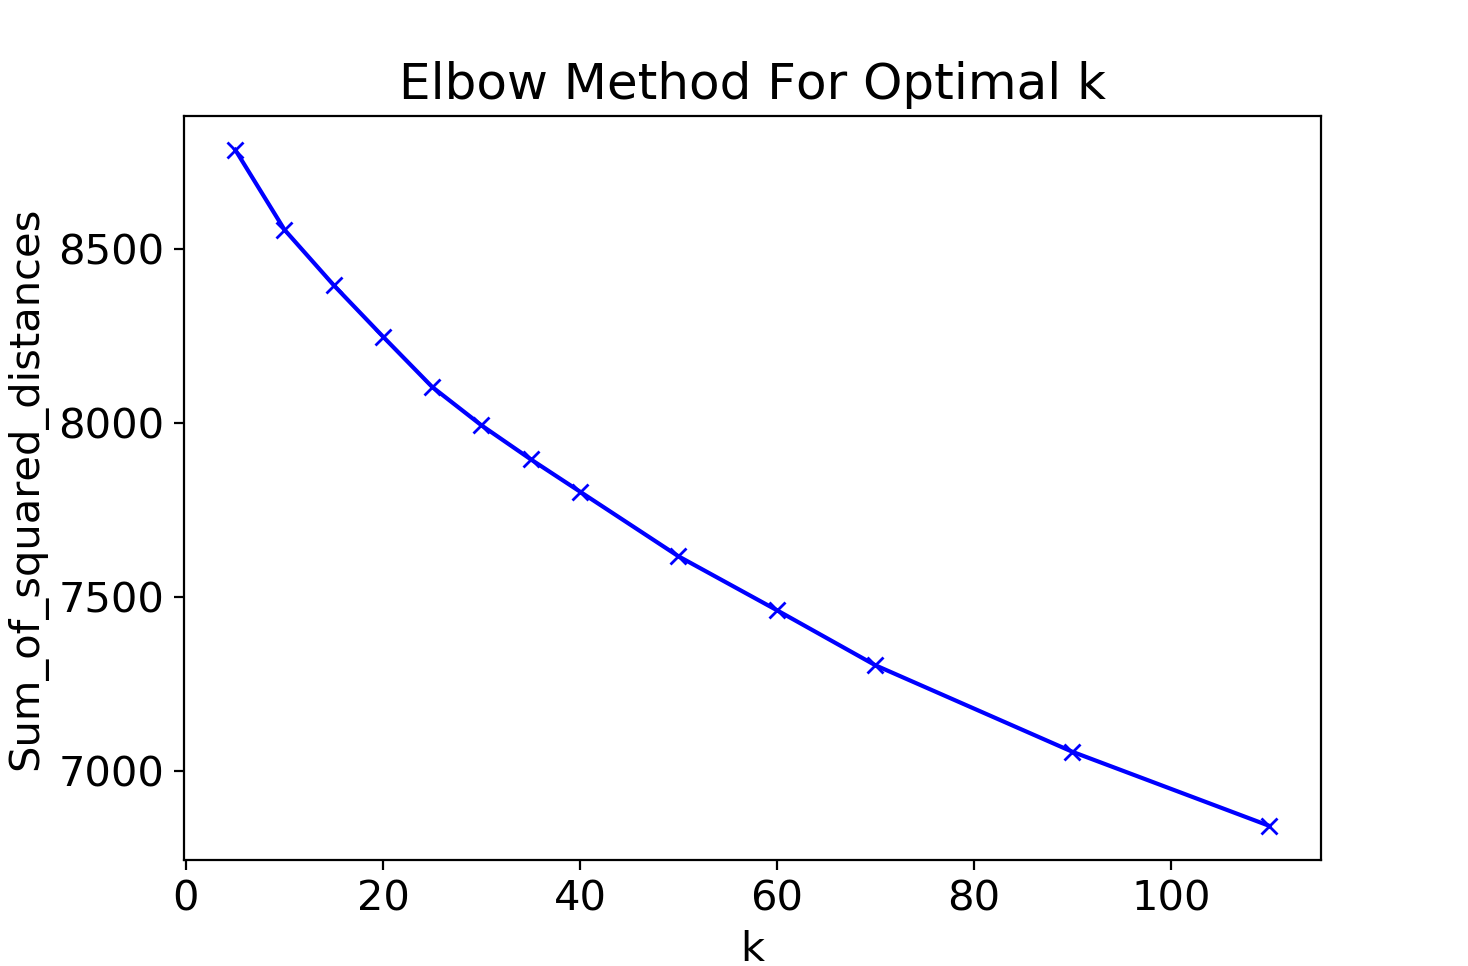

In [683]:
plt.plot([5,10,15,20,25,30,35,40,50,60,70,90,110], Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

widget visualization for cluster content

In [ ]:
#preprocess, tokenize (bigrams, trigrams, vectorize, transform (tfidf, lsi, lda), cluster/classify

### Evaluation of clusters

## Other Embeddings

## Labeling with macros

In [700]:
tcdf = df[df.comment_text.str.contains('Thank you for contacting us')].copy()

In [701]:
def phrase_label(text):
    
    e = ['Yes, we currently write', 'The class code for']
    ne = ['currently do not write', 'not an eligible class', 'nfortunately']
    
    if any([phrase in text for phrase in e]):
        return 'eligible'
    elif any([phrase in text for phrase in ne]):
        return 'not eligible'
    elif 'reason you were declined' in text:
        return 'declined'
    else:
        return None

In [702]:
#count nulls
tcdf['label'] = tcdf.comment_text.map(phrase_label)

In [703]:
tcdf.head()

t_id           t_created                r_name          r_id  \
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
5  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   
7  148929 2019-09-19 21:21:50        Georgette Diaz  377333939872   
9  148925 2019-09-19 21:19:42     Vincent Mosomillo  363659707672   

           a_id    a_name                     subject  \
1  374984390592  Shane C.           Chat with Jeannie   
3  374984390592  Shane C.            Chat with denise   
5  374984390592  Shane C.         Chat with jeff wolf   
7  374984390592  Shane C.    Chat with georgette diaz   
9  374984390592  Shane C.  Chat with Vncent Mosomillo   

                                        comment_text text_type         label  
1  Hi Jeannie,\nThank you for contacting us. The ...     macro      eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...     macro  not eligible  
5  Hi Jeffrey,\nThank you for contacting us.\nYes...     macro      eligible  
7  Hi Georgette,\nThank you for contacting us.\nA...     macro  not eligible  
9  Hi Vincent,\nThank you for contacting us.\nAt ...     macro  not eligible

In [704]:
tcdf.label.isnull().sum()

112

In [705]:
tcdf.label.value_counts()

not eligible    844
eligible        463
declined         64
Name: label, dtype: int64

Check distributions of macro responses vs general chat

In [514]:
# df.drop('label',axis=1,inplace=True)

In [12]:
df['text'] = df.comment_text.str.contains('Thank you for contacting us').map(lambda x: 'macro' if x else 'chat')

In [532]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

<IPython.core.display.Javascript object>


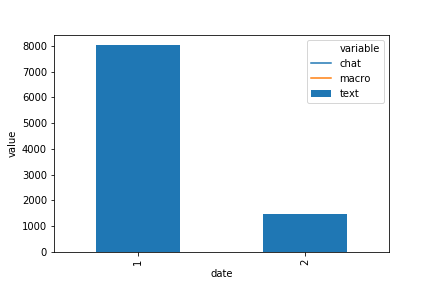

In [553]:
#number of tickets that include macro responses for labeling
df.groupby('t_id')['text'].nunique().value_counts().plot.bar()

In [554]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text   text  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   chat  
1  Hi Jeannie,\nThank you for contacting us. The ...  macro  
2   \n(09:22:45 PM) denise: Do you allow electric...   chat  
3  Hi Denise,\nThank you for contacting us.\nAt t...  macro  
4   \n(09:21:52 PM) jeff wolf: what is best class...   chat

In [559]:
ttdf = df[['t_created','text']].copy()

In [572]:
ttdf['date'] = ttdf.t_created.map(lambda x: x.date())

In [616]:
ts = ttdf.groupby(['date','text']).count().unstack(fill_value=0)

In [630]:
ts.columns = ['chat','macro']

In [632]:
ts.head()

chat  macro
date                   
2018-02-16     1      0
2018-02-20    18      0
2018-02-21    10      1
2018-02-22    14      1
2018-02-23    10      0

In [643]:
#long form for seaborn plotting
ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']).head()

date variable  value
0  2018-02-16     chat      1
1  2018-02-20     chat     18
2  2018-02-21     chat     10
3  2018-02-22     chat     14
4  2018-02-23     chat     10

Number of tickets per day that have macro responses. Ideal would be all?

<IPython.core.display.Javascript object>


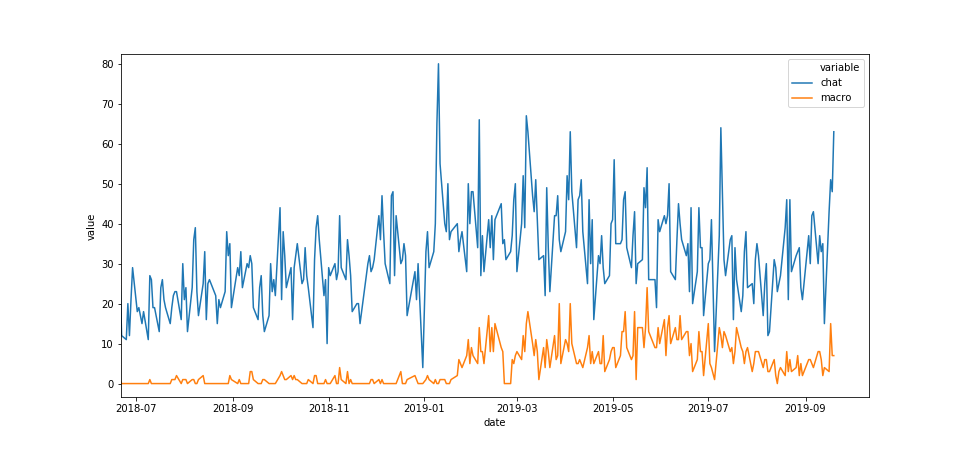

In [646]:
fig, ax= plt.subplots()
sns.lineplot(x='date', y='value',hue='variable',
             data=ts.reset_index().melt(id_vars=['date'], value_vars=['chat','macro']),ax=ax)

Apply template phrases to larger dataset (need to verify accuracy of phrases)

In [447]:
df.head()

t_id           t_created                r_name          r_id  \
0  148945 2019-09-19 21:58:13               Jeannie  363946897231   
1  148945 2019-09-19 21:58:13               Jeannie  363946897231   
2  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
3  148932 2019-09-19 21:23:26  Denise Mullen-Martin  381631813431   
4  148931 2019-09-19 21:23:20          Jeffrey Wolf  386156610311   

           a_id    a_name              subject  \
0  374984390592  Shane C.    Chat with Jeannie   
1  374984390592  Shane C.    Chat with Jeannie   
2  374984390592  Shane C.     Chat with denise   
3  374984390592  Shane C.     Chat with denise   
4  374984390592  Shane C.  Chat with jeff wolf   

                                        comment_text         label  
0   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...          None  
1  Hi Jeannie,\nThank you for contacting us. The ...      eligible  
2   \n(09:22:45 PM) denise: Do you allow electric...  not eligible  
3  Hi Denise,\nThank you for contacting us.\nAt t...  not eligible  
4   \n(09:21:52 PM) jeff wolf: what is best class...  not eligible

In [415]:
df['label'] = df.comment_text.map(phrase_label)

In [422]:
df.label.value_counts()/12845

not eligible    0.325963
eligible        0.036902
declined        0.005216
Name: label, dtype: float64

In [455]:
print(df[df.label=='not eligible'].comment_text[16])

 
(08:26:38 PM) Michelle Lee: Good Afternoon
I have a risk that is a lessors Risk
they have 2 Whole sales tenants - one is Jewelry and the other is a camera distributor
can we entertain this risk?
(08:27:30 PM) Michelle Lee: Hi Ashl'Y
(08:28:17 PM) Ashl'Y M.: hey Michelle the jewelry wholesale is okay
(08:28:24 PM) Ashl'Y M.: let me check on the camera
(08:28:26 PM) Ashl'Y M.: One moment please
(08:28:28 PM) Michelle Lee: thank you
(08:33:06 PM) Ashl'Y M.: how much space does the camera occupy
(08:33:54 PM) Michelle Lee: the total sq ft for the building is 10,000
Jewelry - 7,000
Camera Distributor - 3,000
(08:37:34 PM) Ashl'Y M.: okay unfortunately we wouldnt be able to write this because of the camera
(08:37:42 PM) Michelle Lee: thank you for trying
(08:37:44 PM) Michelle Lee: have a great day
(08:37:51 PM) Ashl'Y M.: you as well

